<a href="https://colab.research.google.com/github/prawizard/CE888_Repo/blob/main/Lab_4/my_recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import packages/libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Load the data files

In [2]:
data=pd.read_csv('https://raw.githubusercontent.com/albanda/CE888/master/lab4-recommender/jester-data-1.csv', header=None)

In [3]:
test_data=pd.DataFrame(data)
test_data=pd.concat([test_data.loc[:, 0], test_data.loc[:, 1:].replace(99.00, np.NaN)], axis=1)
test_data.drop(columns=[0], inplace=True)

In [5]:
data=pd.concat([data.loc[:, 0], data.loc[:, 1:].replace(99.00, np.NaN)], axis=1)
data.drop(columns=[0], inplace=True)

In [16]:
val_data=pd.read_csv('https://raw.githubusercontent.com/albanda/CE888/master/lab4-recommender/jester-data-1.csv', header=None)
val_data.drop(columns=[0], inplace=True)
# val_data.head()

# Highest and lowest rated joke

In [10]:
print('Joke with highest rating : ', test_data.max(axis=0).idxmax())
print('Joke with lowest rating : ', test_data.min(axis=0).idxmax())

Joke with highest rating :  45
Joke with lowest rating :  1


In [ ]:
# val_data=pd.DataFrame(data)
# val_data.drop(columns=[0], inplace=True)

# Prepare Validation Data

In [17]:
arr = val_data.values
arr.shape

(24983, 100)

In [19]:
rated = np.where(arr!=99)
print(len(rated[0]), rated[1].shape)

1810455 (1810455,)


In [ ]:
# data.drop(columns=[0], inplace=True)

In [35]:
len(np.where(arr!=99)[1])

1810455

In [21]:
def replace(orig, percentage=0.1):
  """
  Replaces 'percentage'% of the original values in 'orig' with 99's
  :param orig: original data array
  :param percentage: percentage of values to replace (0<percentage<1)
  """
  new_data = orig.copy()
  rated = np.where(arr!=99)
  n_rated = len(rated[0])
  idx = np.random.choice(n_rated, size=int(percentage*n_rated), replace=False)
  new_data[rated[0][idx], rated[1][idx]] = 99
  return new_data, (rated[0][idx], rated[1][idx])

In [36]:
new_arr, idx = replace(arr, 0.1)

In [37]:
arr[idx[0][0], idx[1][0]]

-4.71

In [38]:
new_arr[idx[0][0], idx[1][0]]

99.0

In [39]:
val_data=pd.DataFrame(new_arr)
val_data=pd.DataFrame(val_data.loc[:, 0:].replace(99.00, np.NaN))
val_data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,NaN,8.79,-9.66,-8.16,-7.52,-8.50,-9.85,4.17,-8.98,-4.76,-8.50,-6.75,-7.18,8.45,-7.18,-7.52,-7.43,-9.81,-9.85,-9.85,-9.37,1.50,-4.37,NaN,-8.50,1.12,7.82,2.86,NaN,-7.43,2.14,-4.08,-9.08,7.82,5.05,4.95,-9.17,-8.40,-8.40,-8.40,...,8.59,3.59,-6.84,-9.03,2.82,-1.36,-9.08,8.30,5.68,-4.81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9.42,NaN,NaN,NaN,-7.72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.82,NaN,NaN,NaN,NaN,NaN,-5.63,NaN,NaN,NaN
1,NaN,-0.29,6.36,4.37,-2.38,-9.66,-0.73,-5.34,8.88,9.22,6.75,8.64,4.42,7.43,4.56,-0.97,4.66,-0.68,3.30,-1.21,0.87,8.64,8.35,9.17,0.05,7.57,4.71,0.87,-0.39,6.99,6.50,-0.92,7.14,9.03,-1.80,0.73,7.09,3.40,-0.87,7.91,...,-6.70,-3.35,-9.03,4.47,NaN,-3.83,8.74,1.12,0.78,7.52,-5.0,2.77,8.3,7.77,7.33,NaN,7.72,8.98,8.64,8.20,3.93,NaN,4.85,6.07,8.98,4.51,-0.05,3.69,4.56,0.58,2.82,-4.95,-0.29,7.86,-0.19,-2.14,3.06,0.34,-4.32,1.07
2,NaN,NaN,NaN,NaN,NaN,9.27,NaN,9.27,NaN,NaN,7.33,7.57,9.37,6.17,-6.36,-6.89,-7.86,9.03,9.03,9.03,7.28,NaN,8.25,NaN,NaN,NaN,7.28,7.28,8.93,NaN,6.17,7.28,NaN,NaN,8.98,7.33,NaN,6.17,9.08,7.33,...,6.46,7.28,NaN,NaN,7.04,7.28,NaN,7.28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.03,NaN,NaN,NaN,9.08,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,8.35,NaN,NaN,1.80,NaN,-2.82,6.21,NaN,1.84,7.33,6.60,6.31,8.11,-7.23,-6.65,1.17,-6.60,-3.64,-2.09,5.34,NaN,NaN,NaN,NaN,2.91,3.93,6.75,6.60,NaN,6.65,-6.12,NaN,7.57,6.21,6.65,NaN,-8.30,7.18,2.82,...,0.00,-3.69,NaN,NaN,7.82,0.24,NaN,7.28,-2.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.63,NaN,NaN,-2.33,NaN,NaN,NaN,NaN,NaN,0.53,NaN,NaN,NaN,NaN,NaN,NaN
4,8.5,4.61,-4.17,NaN,1.36,1.60,NaN,4.61,-0.44,5.73,8.25,6.84,-3.93,7.23,-2.33,-9.66,2.72,-1.36,2.57,4.51,8.20,6.12,8.30,-1.26,7.77,1.89,NaN,5.68,8.45,4.61,8.06,-9.47,7.28,5.68,2.48,3.20,-1.26,6.80,4.51,2.48,...,7.38,6.17,4.71,-2.28,7.38,4.56,7.14,4.22,3.01,3.83,NaN,NaN,NaN,NaN,NaN,NaN,4.13,NaN,NaN,NaN,NaN,5.92,0.87,7.28,3.93,NaN,6.31,4.71,2.82,2.96,5.19,5.58,4.27,5.19,5.73,1.55,3.11,6.55,1.80,1.60


# Training

In [40]:
n_latent_factors = 2

user_ratings = data.values
# Initialise as random values
latent_user_preferences = np.random.random((user_ratings.shape[0], n_latent_factors))
latent_item_features = np.random.random((user_ratings.shape[1], n_latent_factors))

In [41]:
def predict_rating(user_id, item_id):
    """ Predict a rating given a user_id and an item_id.
    """
    user_preference = latent_user_preferences[user_id]
    item_preference = latent_item_features[item_id]
    return user_preference.dot(item_preference)


def train(user_id, item_id, rating, alpha=0.0001):
    #print(item_id)
    predicted_rating = predict_rating(user_id, item_id)
    err =  predicted_rating - rating
    #print(err)
    user_pref_values = latent_user_preferences[user_id]
    latent_user_preferences[user_id] -= alpha * err * latent_item_features[item_id]
    latent_item_features[item_id] -= alpha * err * user_pref_values
    return err
    

def sgd(iterations):
    """ Iterate over all users and all items and train for 
        a certain number of iterations
    """
    mse_history = []
    for iteration in range(iterations):
        error = []
        for user_id in range(latent_user_preferences.shape[0]):
            for item_id in range(latent_item_features.shape[0]):
                rating = user_ratings[user_id, item_id]
                if not np.isnan(rating):
                    err = train(user_id, item_id, rating)
                    error.append(err)
        mse = (np.array(error) ** 2).mean()   
        if (iteration % 10) == 0:
            print('Iteration %d/%d:\tMSE=%.6f' % (iteration, iterations, mse))
            mse_history.append(mse)
    return mse_history

In [42]:
num_iter = 100
hist = sgd(num_iter)  # Note how the MSE decreases with the number of iterations

Iteration 0/100:	MSE=26.168640
Iteration 10/100:	MSE=23.079744
Iteration 20/100:	MSE=21.269400
Iteration 30/100:	MSE=19.881378
Iteration 40/100:	MSE=17.762604
Iteration 50/100:	MSE=17.264157
Iteration 60/100:	MSE=17.169471
Iteration 70/100:	MSE=17.142136
Iteration 80/100:	MSE=17.133488
Iteration 90/100:	MSE=17.130864


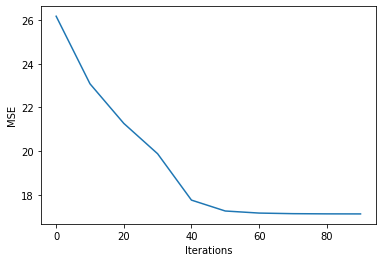

In [43]:
plt.figure()
plt.plot(np.arange(0, num_iter, 10), hist)
plt.xlabel("Iterations")
plt.ylabel("MSE")
plt.show()

# Predicting

In [44]:
predictions = latent_user_preferences.dot(latent_item_features.T)
predictions

array([[-3.9101401 , -4.1844387 , -5.64195569, ..., -2.45224069,
        -6.1897599 , -2.57000198],
       [ 2.98954261,  3.16000607,  3.79311712, ...,  2.51727586,
         3.95099265,  2.76085415],
       [ 6.85944894,  7.15620287,  7.45190169, ...,  7.32018918,
         7.18678963,  8.24820292],
       ...,
       [-0.86193823, -0.91787697, -1.18367082, ..., -0.61464187,
        -1.27433447, -0.65830683],
       [-1.99891995, -2.14812538, -3.00332151, ..., -1.10666616,
        -3.34306373, -1.13174253],
       [ 2.78608002,  2.86827047,  2.51832308, ...,  3.60065441,
         2.15576198,  4.12755194]])

# Predicting on Validation set

In [50]:
val_data=pd.read_csv('https://raw.githubusercontent.com/albanda/CE888/master/lab4-recommender/jester-data-1.csv', header=None)
val_data.drop(columns=[0], inplace=True)
val_data=pd.DataFrame(val_data.loc[:, 0:].replace(99.00, np.NaN))

v_data=pd.DataFrame(new_arr)
v_data=pd.DataFrame(v_data.loc[:, 0:].replace(99.00, np.NaN))

v_user_ratings=v_data.values

v_values = [zip(v_user_ratings[i], predictions[i]) for i in range(predictions.shape[0])]
v_comparison_data = pd.DataFrame(v_values)
v_comparison_data.columns = data.columns

# v_comparison_data

In [51]:
val_user_ratings=val_data.values

error = []

for user_id in range(latent_user_preferences.shape[0]):
    for item_id in range(latent_item_features.shape[0]):
        rating = val_user_ratings[user_id, item_id]
        
        if not np.isnan(rating):
             val_predicted_rating = predict_rating(user_id, item_id)
             err =  val_predicted_rating - rating
             
            #  err = train(user_id, item_id, rating)
             error.append(err)
val_mse = (np.array(error) ** 2).mean()
print('MSE on Validation Set :', val_mse)

MSE on Validation Set : 17.073573555107714


# Predicting on Test Set

In [53]:
test_user_ratings=test_data.values
values = [zip(test_user_ratings[i], predictions[i]) for i in range(predictions.shape[0])]
comparison_data = pd.DataFrame(values)
comparison_data.columns = data.columns
comparison_data

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
0,"(-7.82, -3.910140100118776)","(8.79, -4.184438695345873)","(-9.66, -5.641955693181807)","(-8.16, -9.549705722494409)","(-7.52, -2.6950498901556155)","(-8.5, -1.7700355650102007)","(-9.85, -4.944499038193873)","(4.17, -4.330508115777669)","(-8.98, -8.836797136199456)","(-4.76, -3.7228707949511635)","(-8.5, -1.6094110324709674)","(-6.75, -1.744496488705676)","(-7.18, -6.510420752934809)","(8.45, -1.5744868243527523)","(-7.18, -6.5699615988196065)","(-7.52, -10.024412093527229)","(-7.43, -4.46943151542539)","(-9.81, -5.303390501513845)","(-9.85, -3.839408243080653)","(-9.85, -6.132260467688518)","(-9.37, 0.39917236023390573)","(1.5, -4.3120264496360114)","(-4.37, -6.0989663531971585)","(-9.81, -10.5615103681982)","(-8.5, -4.651062068597813)","(1.12, -1.581591947644815)","(7.82, 3.4226725719377904)","(2.86, -1.6863967620757594)","(9.13, 3.4861383970888147)","(-7.43, -7.924678858060033)","(2.14, 1.1050243749349662)","(-4.08, 3.230772824480389)","(-9.08, -9.43524632716985)","(7.82, -2.7048045349939454)","(5.05, 2.8468488044344338)","(4.95, 3.677915372967918)","(-9.17, -9.134241641498674)","(-8.4, -3.4623795213690145)","(-8.4, -2.5232523724171494)","(-8.4, -3.681078123291366)",...,"(8.59, 1.2081870518455884)","(3.59, 2.1072671205350417)","(-6.84, -5.404445411993485)","(-9.03, -8.325673636222989)","(2.82, 1.3410253345214356)","(-1.36, 1.5207278507558821)","(-9.08, -8.801516770524481)","(8.3, 1.7427717251742119)","(5.68, 1.7599653991379267)","(-4.81, -4.67304771456647)","(nan, -6.768974195031788)","(nan, 1.179561485272741)","(nan, -3.3626856874933044)","(nan, -9.208979161161738)","(nan, -6.039321949882855)","(nan, 0.5626705472120188)","(nan, -4.203292547385073)","(-9.42, -2.253310326691273)","(nan, -5.362383663799526)","(nan, -2.6826072318335243)","(nan, -1.3232191945922265)","(-7.72, -4.627775689508619)","(nan, -0.3424574855509701)","(nan, -4.811224900077976)","(nan, -4.15676036474798)","(nan, -6.246809253283032)","(nan, -1.1276016893746226)","(nan, -1.2581393215378702)","(nan, 3.1914196886042534)","(nan, -5.308907811509765)","(2.82, -1.48225406039546)","(nan, -3.190369084315924)","(nan, 0.24091913850002794)","(nan, -4.7195035495293345)","(nan, -3.9316268999376742)","(nan, -2.8648240006837775)","(-5.63, -2.166543573362345)","(nan, -2.4522406861925248)","(nan, -6.189759896172056)","(nan, -2.570001981925177)"
1,"(4.08, 2.9895426092538395)","(-0.29, 3.160006069850505)","(6.36, 3.7931171201593874)","(4.37, 5.267060678501969)","(-2.38, 2.2253301428957215)","(-9.66, 2.5301765627674313)","(-0.73, 2.9863230922387056)","(-5.34, 2.3315782038447534)","(8.88, 5.069097853226111)","(9.22, 2.9977030738451074)","(6.75, 2.4064759754040814)","(8.64, 2.579906799690287)","(4.42, 3.149697487090718)","(7.43, 2.4973977428973617)","(4.56, 3.02096174960234)","(-0.97, 4.315951074580214)","(4.66, 2.4624697863413822)","(-0.68, 2.953730268230264)","(3.3, 2.7366153291384467)","(-1.21, 3.588247378438737)","(0.87, 1.649140622336931)","(8.64, 3.49901901718034)","(8.35, 4.022087183670387)","(9.17, 5.5083592868680995)","(0.05, 3.5505627675746916)","(7.57, 2.4471714514053917)","(4.71, 0.2579335745042737)","(0.87, 2.407671883021254)","(-0.39, 0.14192225973609207)","(6.99, 4.869483671130696)","(6.5, 1.2715281662558984)","(-0.92, 0.3463835375276199)","(7.14, 5.211719752095795)","(9.03, 2.7873264780917113)","(-1.8, 0.5447719756916294)","(0.73, 0.06657171804350588)","(7.09, 4.853024635993378)","(3.4, 3.0744592388364342)","(-0.87, 2.80923441017967)","(7.91, 3.232540325118585)",...,"(-6.7, 1.3223748514512954)","(-3.35, 0.9024783316528356)","(-9.03, 3.7939371648399676)","(4.47, 4.7199807744010736)","(4.08, 1.1734293638808948)","(-3.83, 1.0931393323051086)","(8.74, 4.950919578531483)","(1.12, 0.962757141647987)","(0.78, 1.0327304437082299)","(

In [58]:
# while 1: pass

# For Quiz

In [70]:
quiz_users=pd.read_excel('movies_latent_factors.xlsx', sheet_name='Users')
quiz_items=pd.read_excel('movies_latent_factors.xlsx', sheet_name='Items')

In [63]:
# quiz_movies

In [65]:
test_data.loc[23435:23438, 56:60]

,56,57,58,59,60
23435,-0.29,-2.23,-9.81,-0.29,-0.29
23436,3.59,-1.46,-9.66,-1.94,1.07
23437,-1.26,NaN,NaN,-6.80,NaN
23438,9.03,-9.22,-8.69,3.16,8.11


In [69]:
comparison_data.loc[23437, 58]

(nan, -8.019239696177484)

In [77]:
quiz_items.loc[quiz_items['Movie ID']==629, 'Factor12']

53    0.452338
Name: Factor12, dtype: float64

In [87]:
(quiz_items.loc[quiz_items['Factor5']==np.max(quiz_items['Factor5']), ['Movie ID', 'Factor5']])

,Movie ID,Factor5
15,121,2.750878


In [89]:
quiz_items.head()

,Movie ID,Title,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,Factor11,Factor12,Factor13,Factor14,Factor15
0,11,Star Wars: Episode IV - A New Hope (1977),-1.521848,-1.038507,2.027269,0.247933,-0.594548,2.513260,-1.848910,0.476710,-0.224146,-0.760681,-0.973915,0.862379,0.403861,1.129616,-0.248806
1,12,Finding Nemo (2003),-0.342185,-0.296586,-0.385962,2.443297,-1.097015,-0.619465,0.572887,0.329516,-0.712228,0.323554,-0.561948,-0.142405,-0.564415,0.506876,1.274993
2,13,Forrest Gump (1994),-2.240888,-0.438815,-2.275177,0.614548,0.904469,0.711919,-0.420876,1.302036,-0.868418,-0.160122,0.633667,0.133138,-0.330276,-2.209004,-0.419092
3,14,American Beauty (1999),-0.634531,2.186059,-0.066681,0.086197,0.517558,-0.185319,-0.412352,0.063841,0.075937,-0.577682,0.526803,-1.465557,-0.819682,0.549010,-0.681191
4,22,Pirates of the Caribbean: The Curse of the Bla...,0.517348,-1.456763,0.369161,0.073903,-0.098332,-0.594722,0.828888,0.033626,-0.707414,0.717877,1.394326,-0.786986,1.429191,0.855746,-2.292566


In [110]:
a=quiz_items.loc[quiz_items['Movie ID']==8358]

In [111]:
a=a.values.squeeze()

In [112]:
a=a[2:]
a

array([0.1254612435522293, -0.1846836856931454, -1.3257366317768604,
       -0.33872401288259174, 0.5344138950050794, -0.19292569791749567,
       -0.42831016818184303, 0.08639926748549187, -0.33228588544004956,
       0.15839832717803923, 0.01295686912424204, 0.4678236973410492,
       0.16033537589107677, -0.7588670152539986, 0.4766352511552939],
      dtype=object)

In [130]:
b=quiz_users.loc[quiz_users['User']==768]

In [135]:
b=b.values.squeeze()

In [136]:
b=b[1:]
b

array([ 0.00081908, -0.00922855, -0.01922806,  0.00270275,  0.01286875,
        0.00665548,  0.00768734,  0.01874699,  0.01470509, -0.00925601,
       -0.01011581, -0.01005119, -0.00210834,  0.04322289, -0.00666964])

In [139]:
quiz_pred=np.dot(b, a.T)

In [142]:
round(quiz_pred, 2)

-0.02

In [144]:
c=quiz_items.loc[quiz_items['Movie ID']==197]
c=c.values.squeeze()
c=c[2:]
c

array([-0.6880903520483415, -1.0785096340532638, -1.331394869897539,
       -0.4773289748383014, 0.7395697351329814, 0.6382104977547886,
       0.06771889989090495, 0.39080939755470473, -0.049157936178380664,
       0.5860527130653354, -1.0852360002809158, 0.49648172827053944,
       1.1235452510306585, -1.5321012682387738, -0.18185329170885758],
      dtype=object)

In [145]:
quiz_pred=np.dot(b, c.T)
round(quiz_pred, 2)

-0.01

In [146]:
u_2067=quiz_users.loc[quiz_users['User']==2067]
u_2067=u_2067.values.squeeze()
u_2067=u_2067[1:]
u_2067

array([-8.32419876e-02,  1.81170624e-01, -3.44267114e-01, -1.97126297e-02,
       -2.43198543e-01,  3.92197164e-02, -9.20858062e-02,  1.14807987e-01,
       -3.64718778e-02,  4.23861148e-02, -1.86812335e-01, -1.27038258e-01,
        1.76660761e-01, -5.58122216e-02, -4.16354710e-05])

In [149]:
all_item_factors=quiz_items.values[:, 2:]

In [151]:
quiz_ratings=np.dot(u_2067, all_item_factors.T)

In [153]:
np.argmax(quiz_ratings)

2

In [172]:
np.argsort(quiz_ratings)[::-1][:2]

array([ 2, 10])

In [173]:
quiz_items.loc[np.argsort(quiz_ratings)[::-1][:2], :]

,Movie ID,Title,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,Factor11,Factor12,Factor13,Factor14,Factor15
2,13,Forrest Gump (1994),-2.240888,-0.438815,-2.275177,0.614548,0.904469,0.711919,-0.420876,1.302036,-0.868418,-0.160122,0.633667,0.133138,-0.330276,-2.209004,-0.419092
10,98,Gladiator (2000),-1.364852,-1.304136,-1.941623,-0.661007,0.128877,0.007048,0.371097,0.086026,-0.133839,0.548053,-0.827216,0.141476,0.735983,-0.338100,-0.175565


In [174]:
u_4940=quiz_users.loc[quiz_users['User']==4940]
u_4940=u_4940.values.squeeze()
u_4940=u_4940[1:]
u_4940

array([-0.11309877,  0.04764329, -0.0530243 ,  0.02483359,  0.0106429 ,
       -0.01205102, -0.04915036,  0.0062524 ,  0.02042851,  0.00434913,
        0.02837151,  0.01022704, -0.00823291, -0.02930419,  0.09051074])

In [175]:
quiz_ratings=np.dot(u_4940, all_item_factors.T)
np.argsort(quiz_ratings)[::-1][:3]

array([ 2, 33, 50])

In [176]:
quiz_items.loc[np.argsort(quiz_ratings)[::-1][:3], :]

,Movie ID,Title,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,Factor11,Factor12,Factor13,Factor14,Factor15
2,13,Forrest Gump (1994),-2.240888,-0.438815,-2.275177,0.614548,0.904469,0.711919,-0.420876,1.302036,-0.868418,-0.160122,0.633667,0.133138,-0.330276,-2.209004,-0.419092
33,278,The Shawshank Redemption (1994),-2.780308,-0.088747,-1.821590,-0.157495,0.323285,-0.114768,0.281397,-0.130262,0.028689,-0.810090,-0.229137,0.587575,0.194144,-0.976664,-0.779991
50,603,The Matrix (1999),-3.063639,-1.319283,-0.043618,-0.994612,-0.954054,0.190838,0.197918,-0.093962,-1.082840,-0.003843,1.377453,-1.668189,-1.348377,0.223797,0.752413
